In [2]:
import numpy as np
import tensorflow as tf
import Hawkes as hk
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import scipy.integrate as si
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
from scipy.optimize import minimize
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

In [1]:
para = {'mu':0.05, 'alpha':1/4, 'beta':4.0}
itv = 60000
model = hk.simulator()
model.set_kernel('exp')
model.set_baseline('const')
model.set_parameter(para)
T = model.simulate([0,itv])
print(len(T))
print(type(T))

NameError: name 'hk' is not defined

In [4]:
class CustomOptimizer(Adam):
    def __init__(self, learning_rate_inner, learning_rate_outer, **kwargs):
        super(CustomOptimizer, self).__init__(**kwargs)
        self.learning_rate_inner = learning_rate_inner
        self.learning_rate_outer = learning_rate_outer

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr_inner = self.learning_rate_inner
        lr_outer = self.learning_rate_outer

        for p, g in zip(params, grads):
            if p.name.startswith('dense') and len(p.shape) > 1:
                new_p = p - lr_inner * g  # Inner layer
            else:
                new_p = p - lr_outer * g  # Outer layer
            self.updates.append(K.update(p, new_p))
        return self.updates

In [5]:
L = [float(T[i]) for i in range(len(T))]

In [6]:
def phi(t, W1, W2, b1, b2):
    return np.exp(b2 + np.dot(W2,np.maximum(W1*t+b1,0)))

In [7]:
def lbda(t, mu, W1, W2, b1, b2, T):
    val = mu
    for tau in T:
        if tau < t:
            val += phi(t-tau, W1, W2, b1, b2)
        else:
            break
    return val

In [8]:
def lbda(t):
    predictions = []
    M = []
    for i in range(len(L)):
        if L[i] < t:
            M.append(t - L[i])
    M = np.array(L)
    predictions.append(model.predict(M))
    predictions_sum = np.sum(predictions)
    return predictions_sum + para['mu']

In [9]:
def neg_log_lh(para1, y, para2):
    s = 0
    for t in T:
        s += np.log10(1+lbda(t))
    I = si.quad(lbda,0,60000)[0]
    return -(s-I)
    

In [10]:
model = Sequential()
model.add(Dense(100, activation='relu', kernel_initializer = tf.initializers.RandomUniform(minval=0, maxval=0.5), input_shape=(1,)))
model.add(Dense(1, activation=lambda x: tf.exp(x), kernel_initializer= tf.initializers.RandomUniform(minval=-0.5, maxval=0)))

learning_rate_inner = 1e-5
learning_rate_outer = 1e-2
optimizer = CustomOptimizer(learning_rate_inner, learning_rate_outer)
model.compile(optimizer=optimizer, loss= neg_log_lh)

c:\Users\zozow\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
epochs = 1
T = tf.constant(T, dtype=tf.float32)
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        predicted_intensity = model(T)
        loss = neg_log_lh(L, predicted_intensity, para['mu'])
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

estimated_kernel = tf.math.cumsum(model.predict(T)[:-1], axis=0)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


AttributeError: 'numpy.float64' object has no attribute '_id'

In [100]:
optimizer = tf.keras.optimizers.Adam()

for epoch in range(2):
    for t_batch in T:
        with tf.GradientTape() as tape:
            reconstructed_data = model(t_batch)
            loss = neg_log_lh(t_batch, reconstructed_data)  # Fonction de perte non supervisée
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

estimated_kernel = tf.math.cumsum(model.predict(T)[:-1], axis=0)

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input 23.153759002685547. Expected shape (None, 1), but input has incompatible shape ()[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(), dtype=float32)
  • training=None
  • mask=None

In [13]:
def phi(t):
    return (para['alpha']*para['beta']* np.exp(-para['beta']*t))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


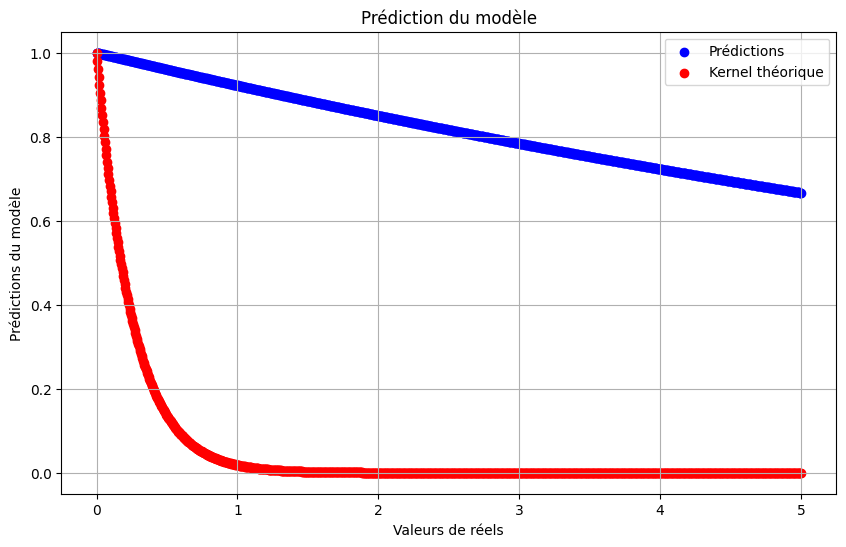

In [15]:
X_test = np.linspace(0,5,1000)
y_true = phi(X_test)  # Les vraies valeurs
y_pred = model.predict(X_test)  # Les prédictions de votre modèle
# Tracer les résultats
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, color='blue', label='Prédictions')
plt.scatter(X_test, y_true, color='red', label='Kernel théorique')
plt.title('Prédiction du modèle')
plt.xlabel('Valeurs de réels')
plt.ylabel('Prédictions du modèle')
plt.legend()
plt.grid(True)
plt.show()

ValueError: x and y must be the same size

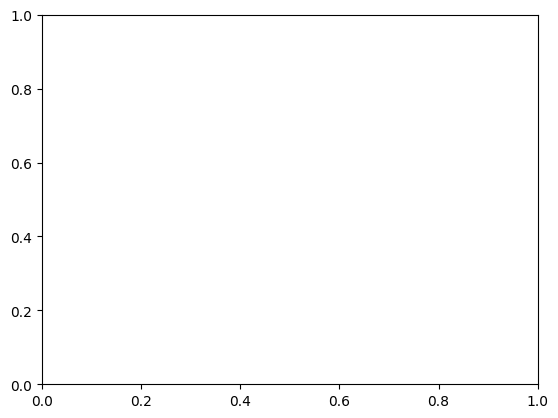

In [14]:
erreur = abs(y_true - y_pred)
plt.scatter(X_test, erreur, color='blue', label='Erreurs')
plt.ylim(0,0.2)

In [16]:
def lbda(t):
    mu = para['mu']
    s=0
    for i in range(len(T)):
        if T[i]<t:
            s += phi(t-T[i])
    return (mu + s)


In [17]:
def neg_log_lh(para):
    s = 0
    for t in T:
        s += np.log10(lbda(t))
    I = si.quad(lbda,0,600)[0]
    return -(s-I)

In [18]:
def gradient_neg_log_lh(para, centers, lbda):
    gradient = {}
    epsilon = 1e-5  # Petit epsilon pour la différence finie
    
    for key, value in para.items():
        para_plus_epsilon = para.copy()
        para_plus_epsilon[key] += epsilon
        
        para_minus_epsilon = para.copy()
        para_minus_epsilon[key] -= epsilon
        
        gradient[key] = (neg_log_lh(para_plus_epsilon) - neg_log_lh(para_minus_epsilon)) / (2 * epsilon)
    
    return gradient

In [19]:
# Paramètres de l'algorithme
learning_rate = 0.1
num_iterations = 30
para_initial = para.copy()  # Point de départ arbitraire

def stochastic_gradient_descent(centers, lbda):
    para = para_initial.copy()
    historique_couts = []
    
    for _ in range(num_iterations):
        # Sélectionner aléatoirement un échantillon ou une observation (ici, nous avons un seul échantillon)
        # Mettre à jour le gradient pour chaque paramètre du dictionnaire
        gradient = gradient_neg_log_lh(para, centers, lbda)
        
        # Mettre à jour les paramètres en utilisant le gradient
        for key in para:
            para[key] -= learning_rate * gradient[key]
        
        # Calculer le coût et l'ajouter à l'historique
        cout = neg_log_lh(para)
        historique_couts.append(cout)
    
    return para, historique_couts

# Now we will replicate the results with the power law kernel

In [18]:
model = hk.simulator()
model.set_kernel('pow')
model.set_baseline('const')
para2 = {'mu':0.05, 'k':1.0, 'p':4.0, 'c':1.0}
model.set_parameter(para2)
itv = [0,60000] # the observation interval
T = model.simulate(itv)
print(np.shape(T))

(4485,)


In [8]:
model = Sequential()
model.add(Dense(150, activation='relu', kernel_initializer = tf.initializers.RandomUniform(minval=0, maxval=0.5), input_shape=(1,)))
model.add(Dense(1, activation=lambda x: tf.exp(x)))
model.compile(optimizer='adam', loss='mse')
para2 = {'mu':0.05, 'k':1.0, 'p':4.0, 'c':1.0}


In [9]:
def phi2(t):
    result = para2['k']*((t+para2['c'])**(-para2['p']))
    return result
    

In [10]:
X =  np.array([[x] for x in np.arange(0, 5, 0.01)]).astype(np.float32)
y = phi2(X)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

model.fit(X_train, y_train, epochs=30, batch_size=50)

Epoch 1/30

8/8 [==============================] - 2s 8ms/step - loss: 0.0149
Epoch 2/30
8/8 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 3/30
8/8 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 4/30
8/8 [==============================] - 0s 5ms/step - loss: 7.5905e-04
Epoch 5/30
8/8 [==============================] - 0s 6ms/step - loss: 6.5407e-04
Epoch 6/30
8/8 [==============================] - 0s 5ms/step - loss: 6.3009e-04
Epoch 7/30
8/8 [==============================] - 0s 5ms/step - loss: 5.7967e-04
Epoch 8/30
8/8 [==============================] - 0s 5ms/step - loss: 5.0913e-04
Epoch 9/30
8/8 [==============================] - 0s 5ms/step - loss: 4.5707e-04
Epoch 10/30
8/8 [==============================] - 0s 6ms/step - loss: 3.9947e-04
Epoch 11/30
8/8 [==============================] - 0s 5ms/step - loss: 3.5359e-04
Epoch 12/30
8/8 [==============================] - 0s 5ms/step - loss: 3.1946e-04
Epoch 13/30
8/8 [===================

4/4 [==============================] - 0s 8ms/step


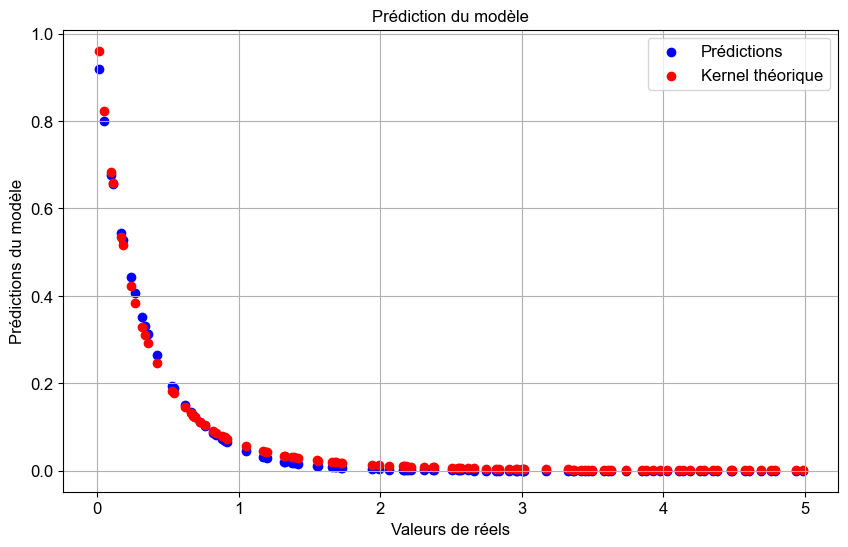

In [11]:
y_true = phi2(X_test)  # Les vraies valeurs
y_pred = model.predict(X_test)  # Les prédictions de votre modèle
# Tracer les résultats
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, color='blue', label='Prédictions')
plt.scatter(X_test, y_true, color='red', label='Kernel théorique')
plt.title('Prédiction du modèle')
plt.xlabel('Valeurs de réels')
plt.ylabel('Prédictions du modèle')
plt.legend()
plt.grid(True)
plt.show()

(0.0, 0.2)

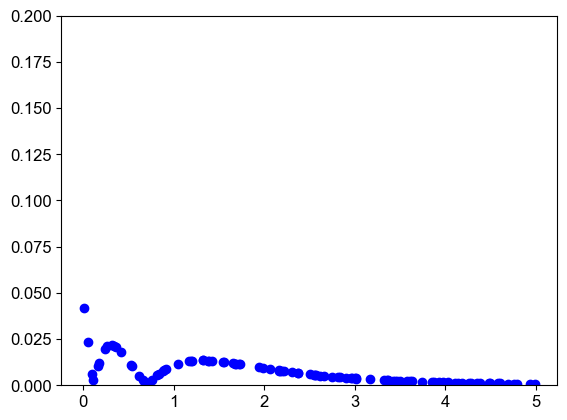

In [12]:
erreur = abs(y_true - y_pred)
plt.scatter(X_test, erreur, color='blue', label='Erreurs')
plt.ylim(0,0.2)